In [1]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

try:
    import numpyro
except ImportError:
    %pip uninstall -y jax jaxlib
    %pip install -q numpyro jax jaxlib

try:
    import arviz
except ImportError:
    %pip install arviz

(classification)=

## GP Classification

In [2]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [3]:
import numpyro
import numpyro.distributions as dist

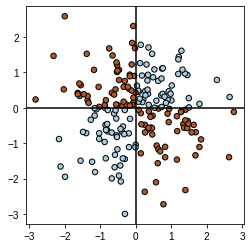

In [4]:
X = jax.random.normal(jax.random.PRNGKey(1234), (200, 2))
y = jnp.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

plt.scatter(
    X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired, edgecolors=(0, 0, 0)
)
plt.gca().set_aspect("equal")
_ = plt.axhline(0, color="k")
_ = plt.axvline(0, color="k")

In [5]:
xs = jnp.linspace(-2, 2, num=100)
ys = jnp.linspace(-2, 2, num=100)

xx, yy = jnp.meshgrid(xs, ys)
xx = xx.T
yy = yy.T
true_X = jnp.vstack((xx.ravel(), yy.ravel())).T
true_y = jnp.logical_xor(true_X[:, 0] > 0, true_X[:, 1] > 0)

In [6]:
def sigmoid(x):
  return 1 / (1 + jnp.exp(-x))

In [7]:
import jax
import jax.numpy as jnp
from flax.linen.initializers import zeros
import numpyro
import numpyro.distributions as dist
from tinygp import kernels, GaussianProcess

jax.config.update("jax_enable_x64", True)

def model(x, y = None):
    # Set up a typical Squared Exponential kernel]
    mean = numpyro.param("mean", jnp.zeros(()))
    sigma = numpyro.param("sigma", jnp.ones(()))
    ell = numpyro.param("ell", jnp.ones(()))

    kernel = (sigma ** 2) * kernels.ExpSquared(scale = ell)

    gp = GaussianProcess(kernel, x, diag=1e-5, mean = mean)

    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())
    l = sigmoid(log_rate)
    numpyro.sample("obs", dist.Bernoulli(probs = l), obs = y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(log_rate, true_X).gp.loc)

nuts_kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=500,
    num_samples=500,
    num_chains=2,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(55873)

/tmp/ipykernel_526948/693015204.py:28: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(


In [8]:
%%time
mcmc.run(rng_key, X, y=y,)
samples = mcmc.get_samples()
pred = samples["pred"].block_until_ready()

sample: 100%|██████████| 1000/1000 [00:34<00:00, 28.79it/s, 1023 steps of size 3.40e-03. acc. prob=0.83]


CPU times: user 22min 12s, sys: 52min 3s, total: 1h 14min 16s
Wall time: 1min 26s


In [9]:
import arviz as az

data = az.from_numpyro(mcmc)
az.summary(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_rate[0],0.997,0.436,0.240,1.802,0.091,0.066,24.0,45.0,1.03
log_rate[1],-2.750,0.462,-3.622,-1.883,0.096,0.071,24.0,134.0,1.07
log_rate[2],-1.593,0.400,-2.253,-0.794,0.113,0.088,15.0,23.0,1.10
log_rate[3],0.152,0.341,-0.421,0.809,0.073,0.052,22.0,56.0,1.06
log_rate[4],-0.365,0.362,-0.960,0.338,0.084,0.060,19.0,86.0,1.10
...,...,...,...,...,...,...,...,...,...
log_rate[195],0.199,0.319,-0.365,0.825,0.068,0.049,22.0,51.0,1.06
log_rate[196],2.089,0.618,1.061,3.372,0.109,0.080,34.0,43.0,1.03
log_rate[197],0.841,0.434,0.039,1.599,0.091,0.067,24.0,42.0,1.03
log_rate[198],0.027,0.371,-0.628,0.693,0.072,0.052,27.0,60.0,1.04


In [10]:
q = np.percentile(samples["log_rate"], [5, 25, 50, 75, 95], axis=0)
y_hat = sigmoid(q[2]) > 0.5

print(f"Accuracy: {(y_hat==y).sum()*100/(len(y)) :0.2f}%")

Accuracy: 98.00%


We see that our model did a reasonable job and got a good accuracy on the train data. Let us now visualize the predictions over a 2d grid.

In [11]:
q = np.percentile(pred, [5, 25, 50, 75, 95], axis=0)
true_y_hat = sigmoid(q[2]) > 0.5
print(f"Accuracy: {(true_y_hat==true_y).sum()*100/(len(true_y)) :0.2f}%")

Accuracy: 97.29%


In [12]:
def plot_pred_2d(arr, xx, yy, contour=False, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = ax.imshow(
        arr,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="equal",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    if contour:
        contours = ax.contour(
            xx,
            yy,
            sigmoid(q[2]).reshape(xx.shape),
            levels=[0.5],
            linewidths=2,
            colors=["k"],
        )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax.get_figure().colorbar(image, cax=cax)
    if title:
        ax.set_title(title)

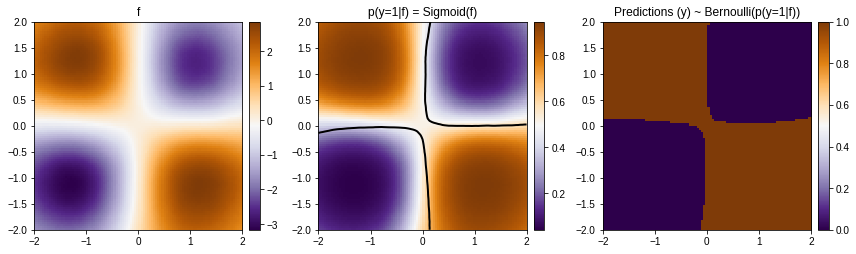

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
plot_pred_2d(q[2].reshape(xx.shape), xx, yy, ax=ax[0], title="f")
plot_pred_2d(
    sigmoid(q[2]).reshape(xx.shape),
    xx,
    yy,
    ax=ax[1],
    title="p(y=1|f) = Sigmoid(f)",
    contour=True,
)
plot_pred_2d(true_y_hat.reshape(xx.shape), xx, yy, ax=ax[2], title="Predictions (y) ~ Bernoulli(p(y=1|f))")

fig.tight_layout()